In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%config Completer.use_jedi = False

# 먼저 ImageDataGenerator를 이용하여 예제 이미지에 Augmentation 적용하기
* ImageDataGenerator는 fit(), flow()를 통해서 입력된 image array(numpy)를 변환시킬 수 있으며, 실제 변환은 next()를 통해 iteration 호출을 해야한다.
* ImageDataGenerator가 입력으로 받는 image array는 batch를 포함한 4차원 array이다. 따라서 단일 이미지를 돌리는 경우 차원 확장을 통해서 batch 반영을 해줘야 한다.
* 변경된 픽셀 값은 float이므로 numpy imshow로 이미지를 보기 위해선 int형으로 변환이 필요.

In [3]:
# sample image
!wget https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg

--2024-02-16 11:32:00--  https://www.sciencenews.org/wp-content/uploads/2020/03/033120_HT_covid-cat_feat-1028x579.jpg
Resolving www.sciencenews.org (www.sciencenews.org)... 52.84.18.54, 52.84.18.47, 52.84.18.121, ...
Connecting to www.sciencenews.org (www.sciencenews.org)|52.84.18.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61745 (60K) [image/jpeg]
Saving to: '033120_HT_covid-cat_feat-1028x579.jpg'

033120_HT_covid-cat 100%[===================>]  60.30K  --.-KB/s    in 0.02s   

2024-02-16 11:32:00 (2.70 MB/s) - '033120_HT_covid-cat_feat-1028x579.jpg' saved [61745/61745]



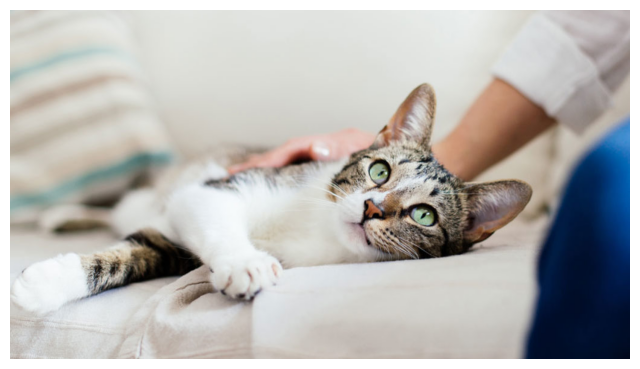

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# cv2.imread를 통해 이미지 파일을 numpy array로 올린다.
# 또한 imread의 경우 이미지가 BGR 순서로 나오므로 이를 RGB 순서로 바꿔주는 작업이 필요하다.
image = cv2.cvtColor(cv2.imread('033120_HT_covid-cat_feat-1028x579.jpg'), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis('off')
    
show_image(image)

## 좌우 반전(Horizontal Flip) 적용을 통한 예시
* 모든 효과는 모두 일괄적으로 적용되는 것은 아니고 랜덤하게 적용 여부가 결정된다.
* horizontal_flip=True를 통해 좌우 반전 적용. 

2024-02-16 11:32:03.830543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 11:32:03.830668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 11:32:04.031592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


image_batch shape: (1, 579, 1028, 3)
aug_image shape: (579, 1028, 3)


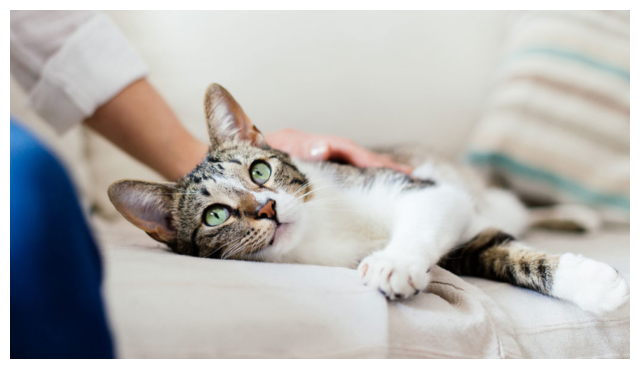

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# horizontal flip 적용. 그러나 무조건적으로 적용되는 것은 아니다.
data_generator = ImageDataGenerator(horizontal_flip=True)

# ImageDataGenerator는 여러개의 image를 입력으로 받기에, batch까지 고려된 4차원 이미지를 넘겨줘야 한다.
image_batch = np.expand_dims(image, axis=0)
print('image_batch shape:', image_batch.shape)

# ImageDataGenerator 적용. fit()후 flow()로 image batch를 넣어주어야 한다.
# 이 단계에선 아직 이미지가 실제로 적용되는 단계는 아니다. 적용을 위한 준비.
data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

# ImageDataGenerator를 동작하기 위해선 next() 등으로 iteration을 호출해야 한다.
aug_image_batch = next(data_gen_iter)

# 변화된 데이터는 batch를 포함한 4차원 array이다.
aug_image = np.squeeze(aug_image_batch)
print('aug_image shape:', aug_image.shape)

# 변환된 pixel값은 float이다. 이를 다시 int형으로 바꾼 후 이미지 시각화 진행.
aug_image = aug_image.astype('int')
show_image(aug_image)

### 여러 ImageDataGenerator 변환을 수행하는 함수 생성
* ImageDataGenerator는 next() 호출이 있을 때마다 random하게 augmentation이 적용되어 반환된다.

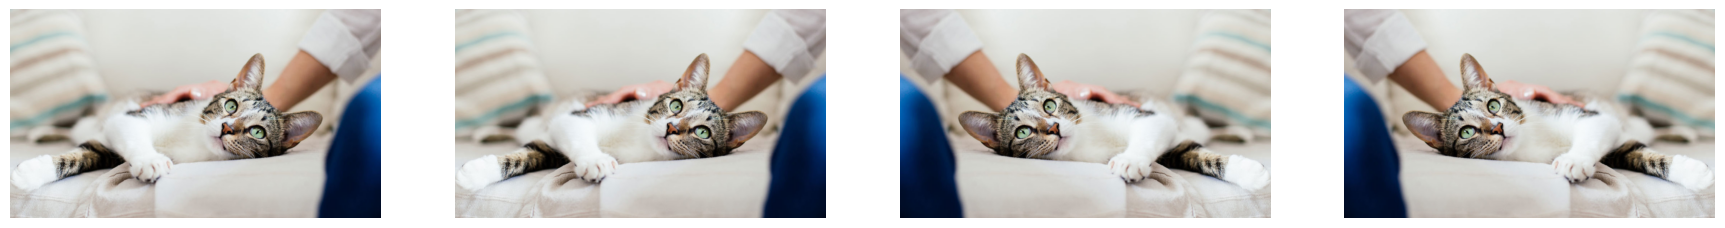

In [6]:
N_IMAGES = 4  # 하나의 이미지에 대해서 4번 반환
fig, axs = plt.subplots(nrows=1, ncols=N_IMAGES, figsize=(22,8))

for i in range(N_IMAGES):
    aug_image_batch = next(data_gen_iter)
    aug_image = np.squeeze(aug_image_batch)
    aug_image = aug_image.astype('int')
    axs[i].imshow(aug_image)
    axs[i].axis('off')

In [7]:
# 위 코드를 함수로 정리한 형태

def show_aug_image_batch(image, data_generator, n_images=4, to_int=True):
    
    image_batch = np.expand_dims(image, axis=0)
    # ImageDataGenerator 적용. fit() 후 flow()로 image batch를 넣어줘야 한다.
    data_generator.fit(image_batch)
    data_gen_iter = data_generator.flow(image_batch)
    
    fig, axs = plt.subplots(nrows=1, ncols=n_images, figsize=(6*n_images, 8))
    
    for i in range(n_images):
        aug_image_batch = next(data_gen_iter)
        aug_image = np.squeeze(aug_image_batch)
        if to_int:
            aug_image = aug_image.astype('int')
        axs[i].imshow(aug_image)
        axs[i].axis('off')

### ImageDataGenerator의 여러 기능들 적용

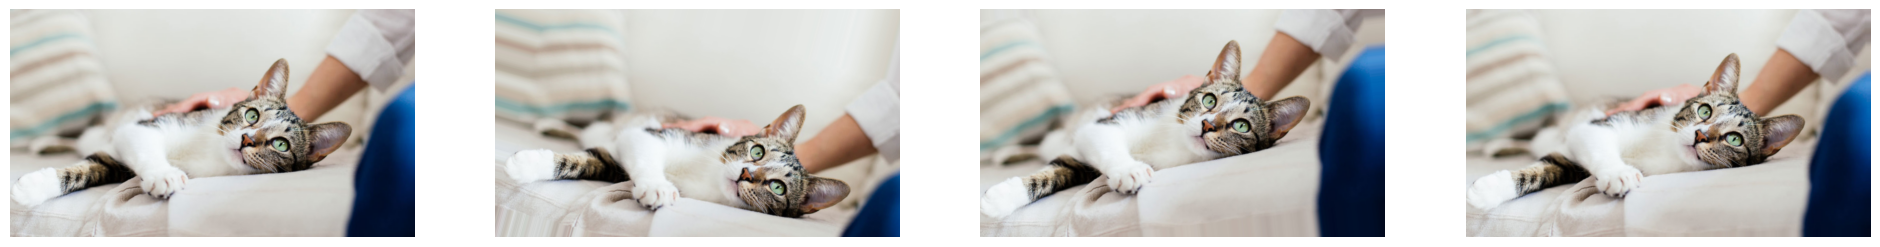

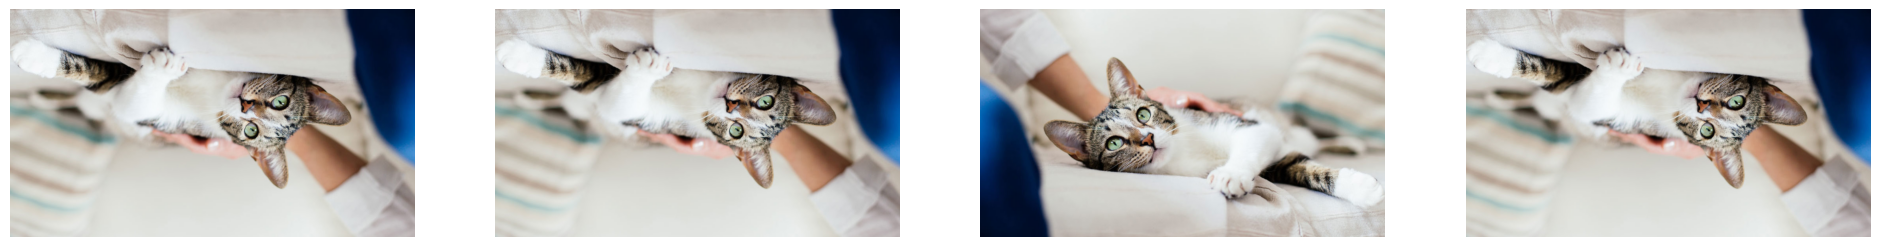

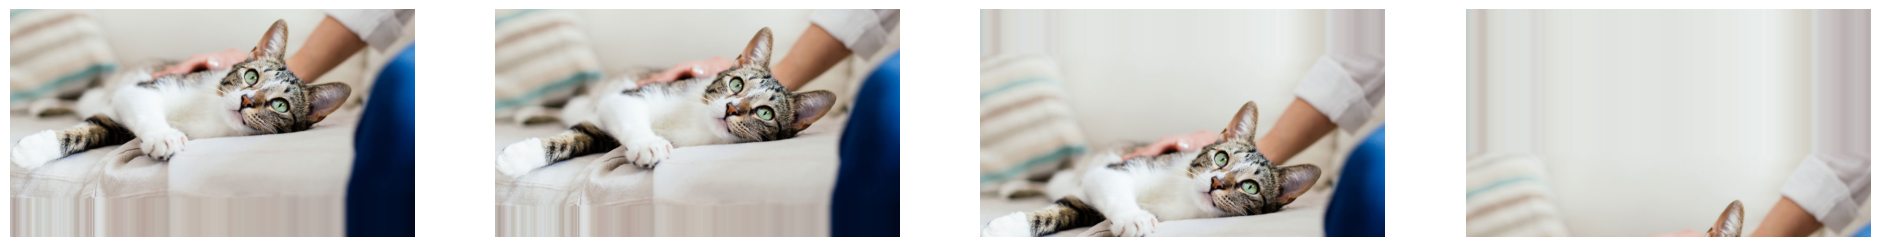

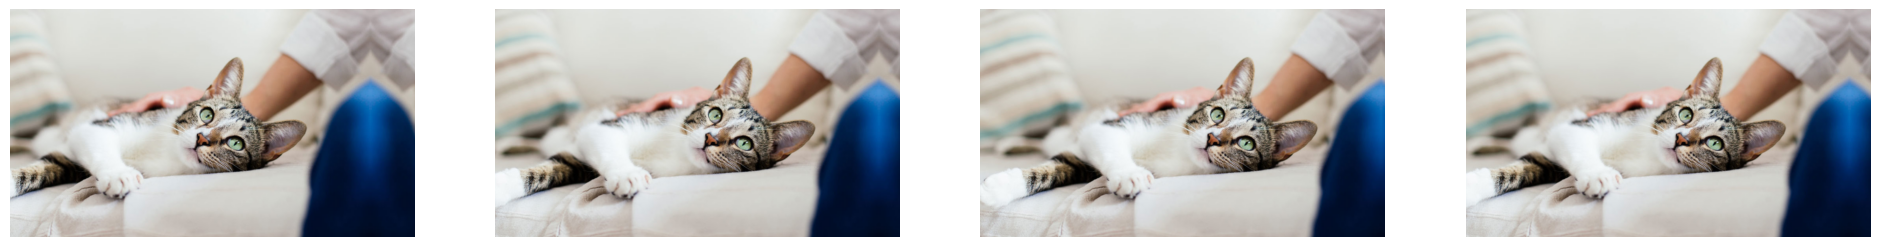

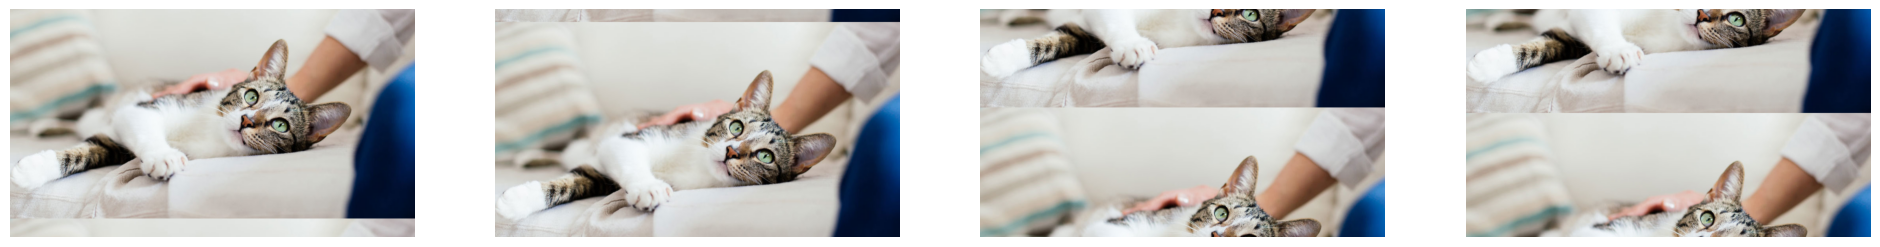

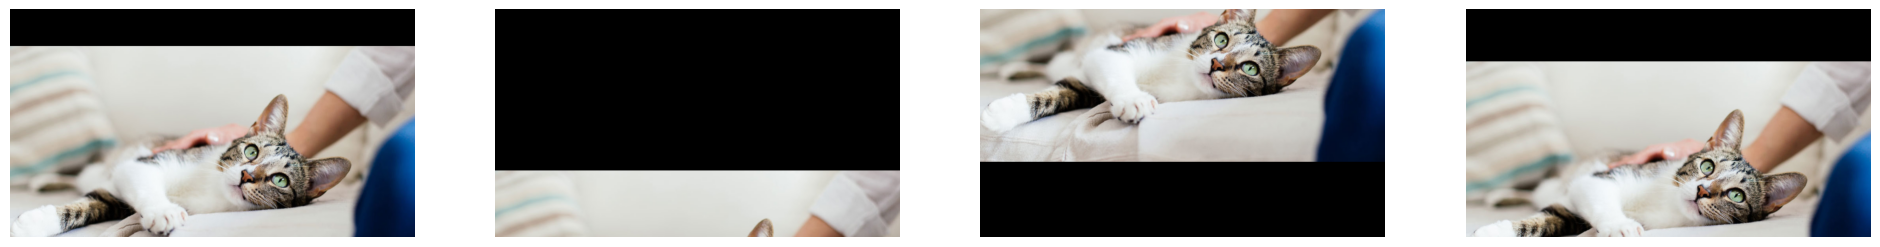

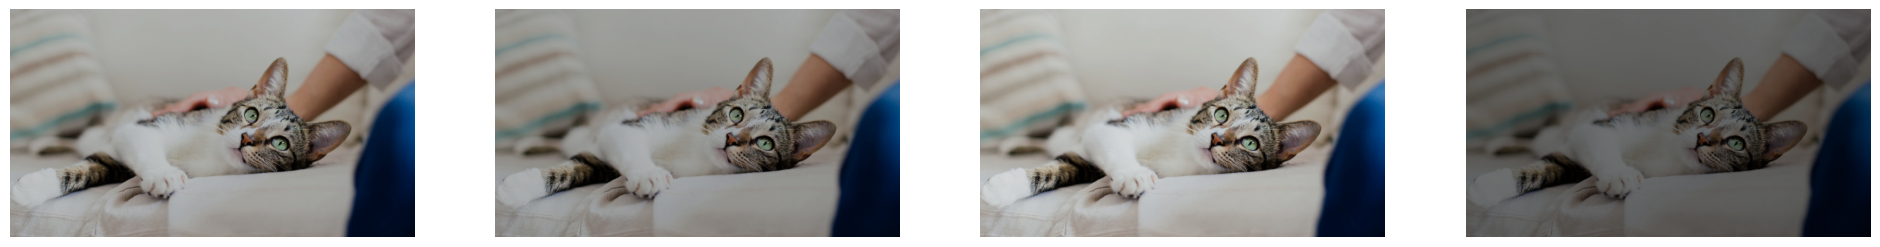

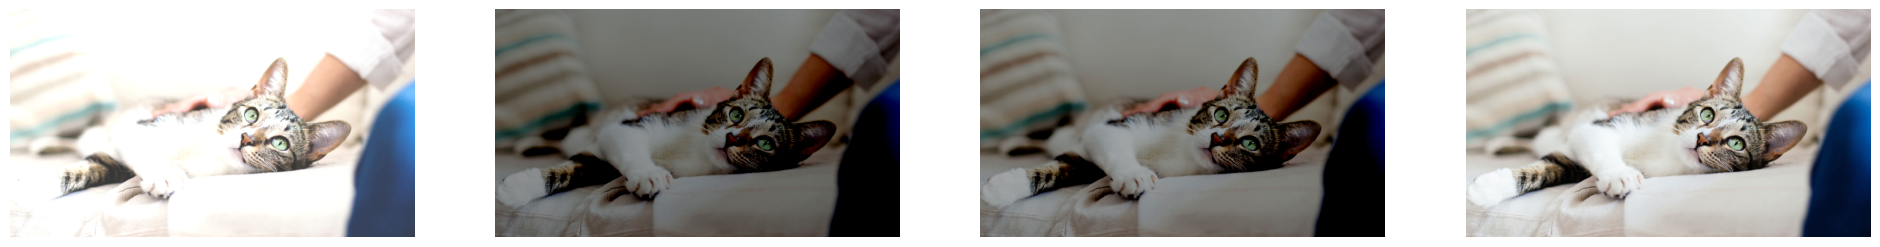

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rotation 범위는 -45 ~ +45로 설정
data_gen = ImageDataGenerator(rotation_range=45)  # fill nearest로 픽셀을 채운다
show_aug_image_batch(image, data_gen, n_images=4)

# horizontal, vertical flip 동시에 적용
data_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
show_aug_image_batch(image, data_gen, n_images=4)

# shift를 통한 이미지 이동
# 이때 이동하면서 남는 공간은 nearest, reflect, wrap, constant 옵션을 통해 채운다.
data_gen = ImageDataGenerator(width_shift_range=0.4, fill_mode='nearest')
show_aug_image_batch(image, data_gen, n_images=4)

data_gen = ImageDataGenerator(height_shift_range=0.4, fill_mode='reflect')
show_aug_image_batch(image, data_gen, n_images=4)

data_gen = ImageDataGenerator(width_shift_range=0.4, fill_mode='wrap')
show_aug_image_batch(image, data_gen, n_images=4)

data_gen = ImageDataGenerator(width_shift_range=0.4, fill_mode='constant', cval=0)
show_aug_image_batch(image, data_gen, n_images=4)

# brightness_range로 0~1 사이 값을 입력해 밝기를 조절한다. 0에 가까우면 어둡고 1에 가까우면 밝아진다.
data_gen = ImageDataGenerator(brightness_range=(0.1, 0.9))
show_aug_image_batch(image,data_gen, n_images=4)

# channel shift 적용
# 원본 이미지의 RGB pixel 값을 channel shift range 범위에 있는 임의의 값으로 변환.
data_gen = ImageDataGenerator(channel_shift_range=150.0)  # -150에서 +150 사이의 값
show_aug_image_batch(image, data_gen, n_images=4)

### Normalization
* 일반적으로 augmentation 용도가 아닌 CNN에 입력된 값으로 pixel값의 변환을 위해 0~1 사이의 값으로 변환하거나 채널별로 z score 변환 적용.
* featurewise_center을 적용하면 RGB 각 픽셀값에서 개별 채널들의 평균 픽셀값을 빼서 평균을 0으로 만든다.
* featurewise_std_normalization을 적용하면 RGB 픽셀값에서 개별 채널들의 표준 편차값으로 나눈다.
* rescale = 255.0은 각 픽셀값을 0~1 사이의 값으로 만들기 위해서 보통 255.0으로 나눈다. 참고로 딥러닝 입력값에 있어선 비교적 작은 값을 선호하는 경향이 있어 이를 맞춰주기 위해서 해당 기능을 사용한다.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
image_batch = np.expand_dims(image, axis=0)

data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

aug_image_batch = next(data_gen_iter)

aug_image = np.squeeze(aug_image_batch)
print(aug_image)

# 출력해보면 평균 0에 표준편차 1에 근접하다.
print(aug_image.mean())
print(aug_image.std())

[[[ 0.21212701  0.42733452  0.43951732]
  [ 0.22730476  0.4433401   0.4569007 ]
  [ 0.2424825   0.45934564  0.47428405]
  ...
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]]

 [[ 0.22730476  0.4433401   0.4569007 ]
  [ 0.2424825   0.45934564  0.47428405]
  [ 0.25766024  0.4433401   0.47428405]
  ...
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]]

 [[ 0.2424825   0.45934564  0.47428405]
  [ 0.27283797  0.45934564  0.4916674 ]
  [ 0.2880157   0.4753512   0.5090508 ]
  ...
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]
  [ 0.13623834  0.02719526  0.09185016]]

 ...

 [[ 0.22730476  0.15523982  0.10923351]
  [ 0.27283797  0.20325653  0.1613836 ]
  [ 0.06034966 -0.0528326  -0.09936678]
  ...
  [-2.6716428  -2.677746   -2.533037  ]
  [-2.6716428  -2.677746   -2.533037  ]
  [-2.6716428  -2.677746   -2.533037  ]]

 [

In [10]:
data_generator = ImageDataGenerator(rescale=1/255.0)
image_batch = np.expand_dims(image, axis=0)

data_generator.fit(image_batch)
data_gen_iter = data_generator.flow(image_batch)

aug_image_batch = next(data_gen_iter)

aug_image = np.squeeze(aug_image_batch)
print(aug_image)

[[[0.75294125 0.7960785  0.7803922 ]
  [0.7568628  0.8000001  0.7843138 ]
  [0.7607844  0.80392164 0.78823537]
  ...
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]]

 [[0.7568628  0.8000001  0.7843138 ]
  [0.7607844  0.80392164 0.78823537]
  [0.76470596 0.8000001  0.78823537]
  ...
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]]

 [[0.7607844  0.80392164 0.78823537]
  [0.7686275  0.80392164 0.79215693]
  [0.7725491  0.8078432  0.7960785 ]
  ...
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]
  [0.73333335 0.69803923 0.7019608 ]]

 ...

 [[0.7568628  0.7294118  0.7058824 ]
  [0.7686275  0.7411765  0.7176471 ]
  [0.7137255  0.6784314  0.65882355]
  ...
  [0.00784314 0.03529412 0.10980393]
  [0.00784314 0.03529412 0.10980393]
  [0.00784314 0.03529412 0.10980393]]

 [[0.72156864 0.69411767 0.67058825]
  [0.7411765  0.7137255  0.6901961 ]


### 종합실습

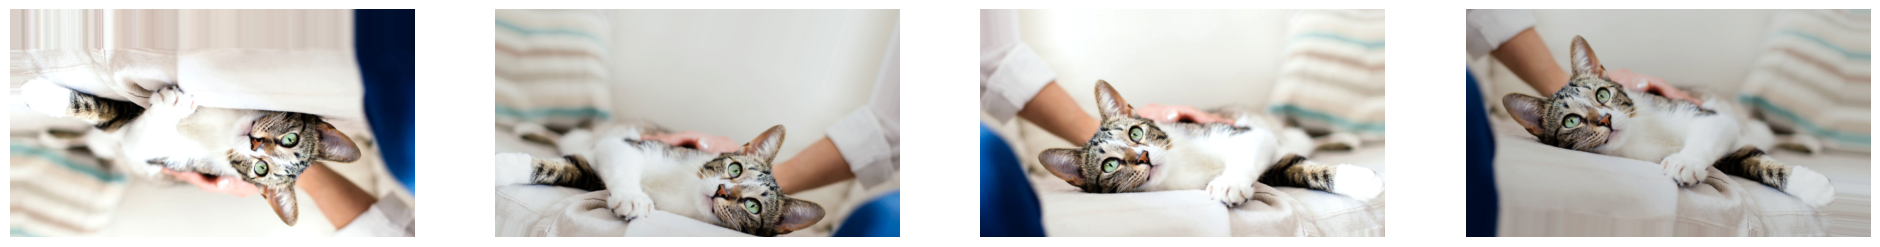

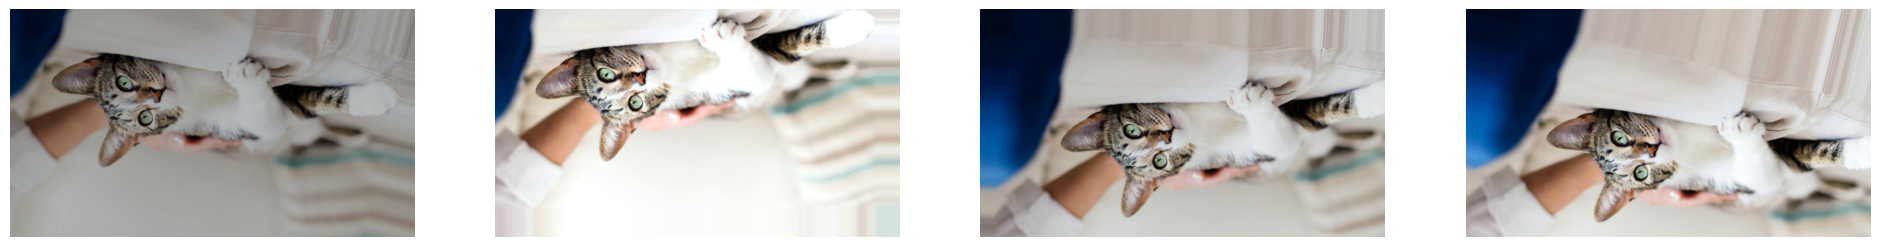

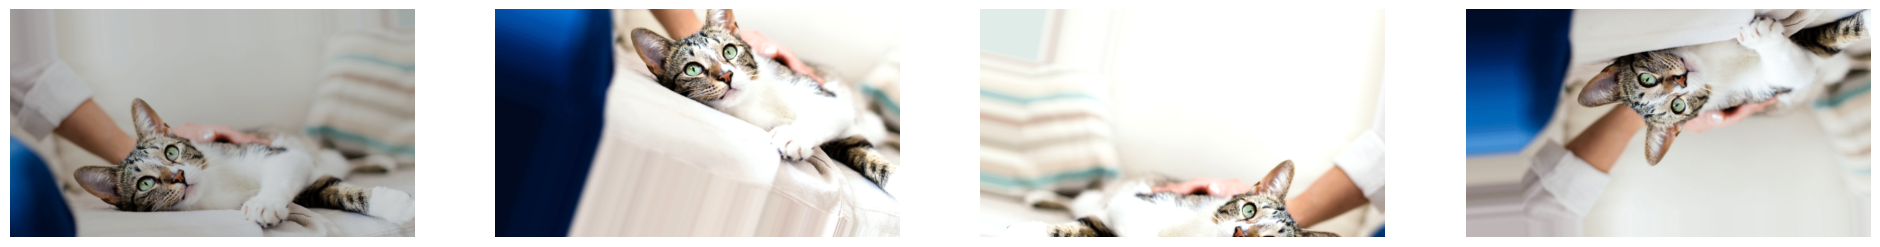

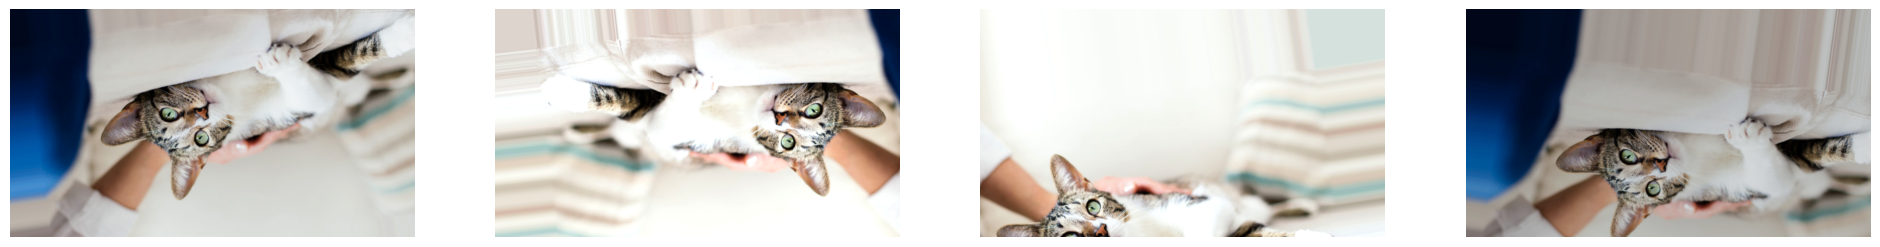

In [11]:
# 일반적으론 아래와 같이 한꺼번에 적용한다.

data_generator = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = (0.7, 1.3),
    horizontal_flip = True,
    vertical_flip = True
)

for i in range(4):
    show_aug_image_batch(image, data_generator, n_images=4)

# CIFAR10 데이터를 이용한 augmentation

In [12]:
# 데이터 전처리

import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 설정
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
# 0 ~ 1 사이의 float32 자료형으로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    if scaling:
        images = np.arary(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42):
    # 학습 및 테스트 데이터 세트를 0~1 사이값 float32로 변경 및 ohe 적용
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images,val_images ,tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)


# random_seed는 42로 고정
set_random_seed(42)
# cifar10 데이터 로딩 및 scaling ohe 적용 후 검증 데이터도 설정
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=42)

print(tr_images.shape, tr_oh_labels.shape)
print(val_images.shape, val_oh_labels.shape) 
print(test_images.shape, test_oh_labels.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10)
(7500, 32, 32, 3) (7500, 10)
(10000, 32, 32, 3) (10000, 10)


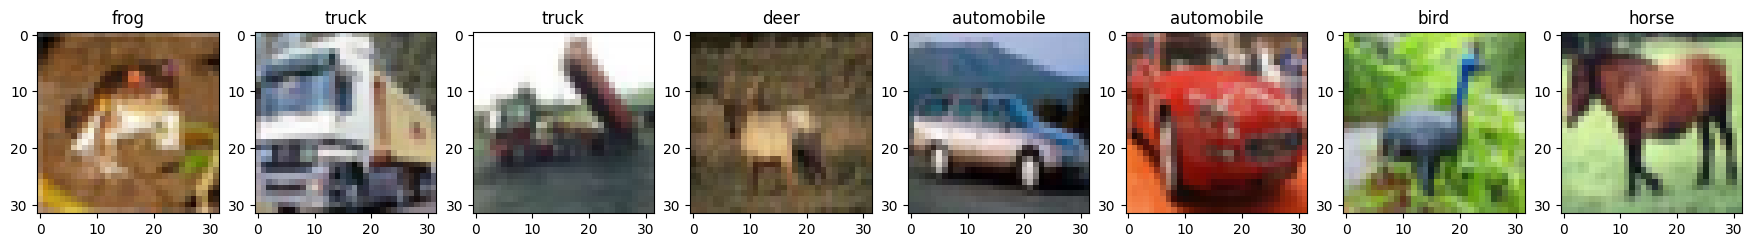

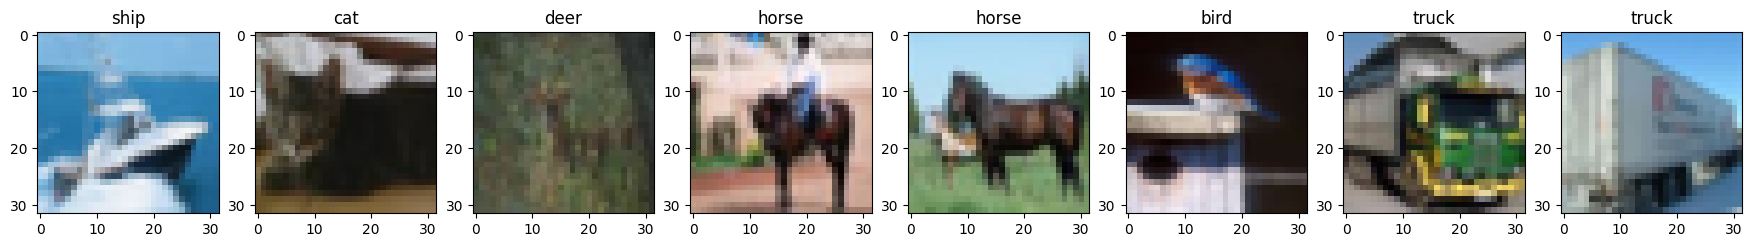

In [13]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

In [14]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

### ImageDataGenerator로 Augmentation 설정하고 학습용, 검증용 Generator 생성

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    rescale=1/255.0
)
# valid data를 위한 generator
# test, validation 데이터는 학습용이 아니라 검증용이라 augmentation 적용하면 안 된다.
valid_generator = ImageDataGenerator(rescale=1/255.0)

# ImageDataGenerator를 이용해 model 이전 단계에서 데이터를 처리해서 model에 주어지는 부담을 완화한다.
# 결국 model.fit에서 처리하던 것들을 generator 생성 후 flow 단계에서 처리한다.
flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

### Keras CNN 모델 생성

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense,Dropout, GlobalAveragePooling2D, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=64, kernel_size=3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Flatten 대신에 GlobalAveragePooling 적용
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model
    
    

In [17]:
model = create_model(verbose=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# callback 섫정
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                            

In [18]:
image_batch, label_batch = next(flow_tr_gen)
print(image_batch.shape, label_batch.shape)
print(image_batch[0], label_batch[0])

(64, 32, 32, 3) (64, 10)
[[[0.18012759 0.16849518 0.18797073]
  [0.17244679 0.16460365 0.18039216]
  [0.16848305 0.16071212 0.18031998]
  ...
  [0.05275317 0.05275317 0.05731602]
  [0.04741104 0.04741104 0.0509804 ]
  [0.04705883 0.04705883 0.05111269]]

 [[0.18074438 0.16933188 0.18893972]
  [0.17331354 0.16508815 0.18115668]
  [0.16903976 0.16119662 0.18039216]
  ...
  [0.05467022 0.05467022 0.06504668]
  [0.04705883 0.04705883 0.05451971]
  [0.04716107 0.04705883 0.05500421]]

 [[0.23459429 0.22218831 0.24607246]
  [0.26237422 0.2493112  0.2741583 ]
  [0.2898651  0.2765074  0.305857  ]
  ...
  [0.06428379 0.0586242  0.0746161 ]
  [0.0505681  0.04705883 0.05841124]
  [0.0510526  0.04698662 0.05882353]]

 ...

 [[0.501672   0.41546968 0.35679057]
  [0.5015485  0.41527402 0.35645047]
  [0.61930627 0.509901   0.4459535 ]
  ...
  [0.18495636 0.15117833 0.1386018 ]
  [0.16372408 0.13135977 0.12161048]
  [0.13991395 0.10895682 0.10210806]]

 [[0.49814147 0.41186696 0.35304344]
  [0.499186 

In [19]:
'''
기존 방식
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=64,epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )
'''

# steps 횟수를 구하기 위해 학습데이터의 건수와 검증 데이터의 건수를 구한다. steps=ceil(학습 데이터 건수/BATCH_SIZE)
# 반면 이젠 batch size도 ImageDataGenerator의 flow 단계에서 처리.
# 결국 모델에 데이터를 집어넣는 역할도 flow 단계에서 처리
# fit에서는 해당 내용을 받아오기만 한다.

history = model.fit(flow_tr_gen, epochs=40, validation_data=flow_val_gen, callbacks=[rlr_cb, ely_cb])

Epoch 1/40


I0000 00:00:1708083175.309998      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


665/665 [==============================] - 47s 53ms/step - loss: 1.5695 - accuracy: 0.4244 - val_loss: 2.0093 - val_accuracy: 0.3840 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 34s 51ms/step - loss: 1.1602 - accuracy: 0.5872 - val_loss: 1.2926 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 34s 51ms/step - loss: 0.9636 - accuracy: 0.6629 - val_loss: 0.8692 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 34s 51ms/step - loss: 0.8501 - accuracy: 0.7073 - val_loss: 0.8828 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 34s 51ms/step - loss: 0.7487 - accuracy: 0.7496 - val_loss: 0.8876 - val_accuracy: 0.6981 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 34s 50ms/step - loss: 0.6827 - accuracy: 0.7681 - val_loss: 1.0086 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 34s 50ms/step -

In [20]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)


157/157 [==============================] - 2s 11ms/step - loss: 0.4365 - accuracy: 0.8585


[0.4365193247795105, 0.8585000038146973]

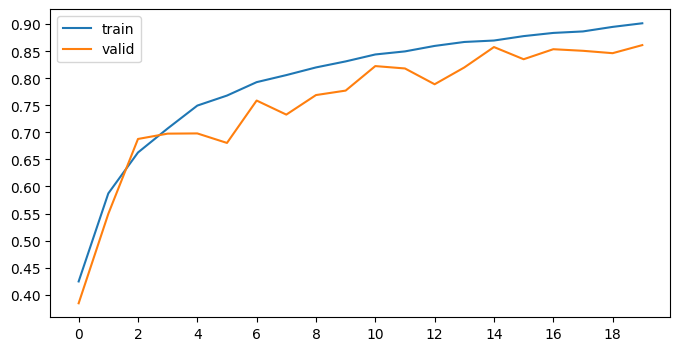

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8,4))
    plt.yticks(np.arange(0,1,0.05))
    plt.xticks(np.arange(0,30,2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### 원본 이미지 상황에 맞지 않는 과도한 Augmentation은 오히려 성능을 저하시킨다.

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 사실 이번 케이스는 aug 자체가 과하기보단 상황에 안 맞는 케이스

train_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=(0.7,0.9), # 이미지가 이미 가운데에 있는 상황에서 확대하면 오히려 성능에 악영향을 준다.
    horizontal_flip=True,
    rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=True)

model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

history = model.fit(flow_tr_gen, epochs=40, validation_data=flow_val_gen, callbacks=[rlr_cb, ely_cb], verbose=1)

Epoch 1/40
665/665 [==============================] - 39s 51ms/step - loss: 1.6002 - accuracy: 0.4208 - val_loss: 1.5929 - val_accuracy: 0.4496 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 34s 51ms/step - loss: 1.2135 - accuracy: 0.5716 - val_loss: 1.5554 - val_accuracy: 0.4987 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 34s 51ms/step - loss: 1.0345 - accuracy: 0.6384 - val_loss: 1.3961 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 33s 50ms/step - loss: 0.9071 - accuracy: 0.6891 - val_loss: 1.8781 - val_accuracy: 0.4859 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 34s 51ms/step - loss: 0.8266 - accuracy: 0.7190 - val_loss: 1.0229 - val_accuracy: 0.6668 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 34s 51ms/step - loss: 0.7477 - accuracy: 0.7478 - val_loss: 1.0716 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 34s 

In [23]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 9ms/step - loss: 0.6292 - accuracy: 0.7919


[0.62923663854599, 0.7918999791145325]

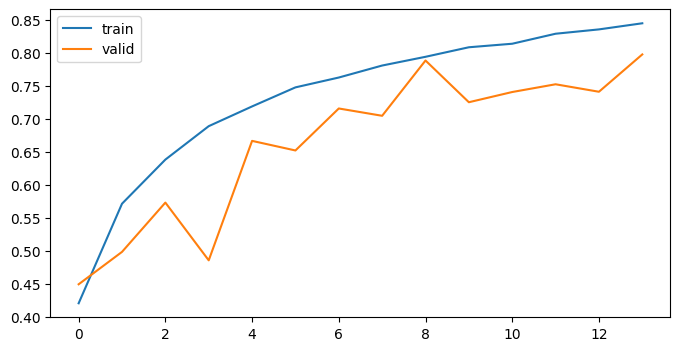

In [24]:
show_history(history)